# 使用tensorflow实现CNN

## 0 开始代码前调通GPU的使用

In [1]:
import tensorflow as tf

# Creates a graph.
with tf.device('/device:GPU:0'):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
  b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
  c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[22. 28.]
 [49. 64.]]


In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
%matplotlib inline
np.random.seed(1)

from cnn_utils import  load_dataset

y=0


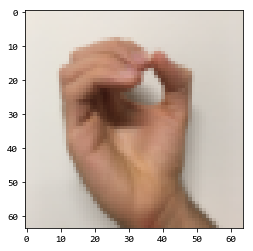

In [3]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

index=1
plt.imshow(X_train_orig[index])
print("y={}".format(np.squeeze(Y_train_orig[:,index])))

- one-hot编码用的是 `np.eye(C)[Y.reshape(-1)].T`代码，原理是numpy 切片; 非常经典的用法


In [4]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.

Y_train=np.eye(6)[Y_train_orig.reshape(-1)].T
print(Y_train.shape)
Y_test=np.eye(6)[Y_test_orig.reshape(-1)].T
print(Y_test.shape)

(6, 1080)
(6, 120)


In [9]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (6, 1080)
X_test shape: (120, 64, 64, 3)
Y_test shape: (6, 120)


# 1 place holder

- Y [None,n_y]

In [10]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    """
    

    Parameters
    ----------
    n_H0: 
    n_W0:
    n_C0:
    n_y: 

    Returns
    -------
    X: (None,n_H0,n_W0,n_C0)
    Y: (None,n_y)
     
    """
    X=tf.placeholder(tf.float32,shape=(None,n_H0,n_W0,n_C0))
    Y=tf.placeholder(tf.float32,shape=(None,n_y))
    return X,Y
    

In [11]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


## 2 初始化参数

- eval方法可以用来观察值

In [12]:
def initialize_parameters():
    """
    W1 [4，4，3,8]
    W2 [2,2,8,16]

    Parameters
    ----------
     : 

    Returns
    -------
    Parameters : dict W1 W2
     
    """    
    tf.set_random_seed(1)
    
    W1=tf.get_variable(name='W1',shape=[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2=tf.get_variable(name='W2',shape=[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))    
    parameters={"W1":W1,"W2":W2}
    return parameters

In [13]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters=initialize_parameters()
    init=tf.global_variables_initializer()
    sess.run(init)
    print("W1 = " + str(parameters['W1'].eval()[1,1,1]))
    print("W2 = " + str(parameters['W2'].eval()[1,1,1]))
    


W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


## 正向传播
- 【bug1】strides=(1,4,4,1)

```
~/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py in conv2d(input, filter, strides, padding, use_cudnn_on_gpu, data_format, dilations, name)
    936       raise TypeError(
    937           "Expected list for 'strides' argument to "
--> 938           "'conv2d' Op, not %r." % strides)
    939     strides = [_execute.make_int(_i, "strides") for _i in strides]
    940     padding = _execute.make_str(padding, "padding")

TypeError: Expected list for 'strides' argument to 'conv2d' Op, not 1.

```

- 【bug2】要用max_pool 而不是pool

```
<ipython-input-111-07ee245ebd1a> in forwar_propagation(X, parameters)
     24     Z2=tf.nn.conv2d(input=P1,filter=W2,strides=(1,4,4,1),padding='SAME')
     25     A2=tf.nn.relu(Z2)
---> 26     P2=tf.nn.pool(input=A2,window_shape=(4,4),strides=(1,4,4,1),pooling_type='MAX',padding='SAME')
     27 
```

- 【bug3】   ` Z3=tf.contrib.layers.fully_connected(P2,num_outputs=6,activation_fn=None)`中
`activation_fn=None`不可缺少


#### 要能够把完整过程推导出来

In [14]:
def forward_propagation(X,parameters):
    """
    正向传播（conv-relu-pool）
    Parameters
    ----------
    X: (m,n_H0,n_W0,n_C0)
    parameters :
        W1 [4，4，3,8]
        W2 [2,2,8,16]
                    
    Returns
    -------
    Z : 
     
    """    
    
    W1=parameters['W1']
    W2=parameters['W2']    
    
    Z1=tf.nn.conv2d(input=X,filter=W1,strides=[1,1,1,1],padding='SAME')
    A1=tf.nn.relu(Z1)
    P1=tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    
    Z2=tf.nn.conv2d(input=P1,filter=W2,strides=(1,1,1,1),padding='SAME')
    A2=tf.nn.relu(Z2)
    P2=tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=(1,4,4,1),padding='SAME')
    P2= tf.contrib.layers.flatten(P2)
    
    Z3=tf.contrib.layers.fully_connected(P2,num_outputs=6,activation_fn=None)
    return Z3


In [15]:
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(1)
    X,Y=create_placeholders(64,64,3,6)
    parameters=initialize_parameters()
    Z3=forward_propagation(X,parameters)
    init=tf.global_variables_initializer()
    sess.run(init)    
    a=sess.run(Z3,feed_dict={X:np.random.randn(2,64,64,3),Y:np.random.randn(2,6)})
    print("Z3 = " + str(a))

Z3 = [[-0.4467027  -1.572088   -1.5304927  -2.3101306  -1.2910441   0.46852106]
 [-0.17601559 -1.5797201  -1.473701   -2.6167207  -1.0081062   0.5747784 ]]


## 3 compute cost

- labels shape= [batch_size, num_classes]


In [18]:
def compute_cost(Z3,Y):
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    return cost
    


In [19]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3=",Z3)
    print("Y=",Y)
    cost = compute_cost(Z3, Y)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))    
    

Z3= Tensor("fully_connected/BiasAdd:0", shape=(?, 6), dtype=float32)
Y= Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)
cost = 2.91034


## 4 Model

- 【bug】<span style="color:red;font-weight:bold"> IndexError: index 858 is out of bounds for axis 0 with size 6</span>
    - 原因： 输入数据维度不对，要进行维度检查

```
<ipython-input-80-3ede693b7bef> in model(X_train, Y_train, X_test, Y_test, learning_rate, num_epoches, minibatch_size, print_cost)
     26             num_minibatches=int(m/minibatch_size)
     27             seed+=1
---> 28             minibatches=random_mini_batches(X_train,Y_train,minibatch_size,seed)
     29 
     30             for minibatch in minibatches:

~/python-workspace/deep-learning-coursera-full/Convolutional Neural Networks/week1/cnn_utils.py in random_mini_batches(X, Y, mini_batch_size, seed)
     44     permutation = list(np.random.permutation(m))
     45     shuffled_X = X[permutation,:,:,:]
---> 46     shuffled_Y = Y[permutation,:]
     47 
     48     # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.

IndexError: index 858 is out of bounds for axis 0 with size 6

```


- [bug] <span style="color:red;font-weight:bold"> cost没有下降</span>
    - 检查原因：之前遇到过问题：计算损失函数时行列颠倒了
    - 发现问题：打印损失函数的代码放在了epoch内部，这是有问题的

```
Cost after epoch 0: 0.124256
Cost after epoch 0: 0.235755
Cost after epoch 0: 0.346379
Cost after epoch 0: 0.460018
Cost after epoch 0: 0.572946
Cost after epoch 0: 0.686253
Cost after epoch 0: 0.799503
Cost after epoch 0: 0.911139
Cost after epoch 0: 1.023798
Cost after epoch 0: 1.136514
Cost after epoch 0: 1.248791
Cost after epoch 0: 1.360714
Cost after epoch 0: 1.472453
Cost after epoch 0: 1.584704
```

- [方法] <span style="color:red;font-weight:bold">计算softmax准确率的方法 </span>

```
        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

```

- 学习率对结果影响很大，过大的学习率导致下降非常缓慢，且比较容易陷入瓶颈期

In [24]:
from cnn_utils import random_mini_batches
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.009,num_epoches=100,minibatch_size=64,print_cost=True):    
    """
    CONV2D-->RELU-->MAXPOOl-->CON2D-->RELU-->MAXPOOL-->FLATTEN-->FC
    

    Parameters
    ----------
    X_train : (None, 64,64,3)
    Y_train : (None, n_y=6)
    X_test: (None, 64,64,3)
    Y_test:(None, n_y=6)

    Returns
    -------
     : 
     
    """    
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed=3
    (m,n_H0,n_W0,n_C0)=X_train.shape
    n_y=Y_train.shape[1]
    costs=[]

    X,Y=create_placeholders(n_H0, n_W0, n_C0, n_y)

    parameters=initialize_parameters()

    Z3=forward_propagation(X, parameters)

    cost=compute_cost(Z3,Y)

    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    init=tf.global_variables_initializer()

    with  tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(init)    
        for epoch in range(num_epoches):

            minibatch_cost=0.
            num_minibatches=int(m/minibatch_size)
            seed+=1            
            minibatches=random_mini_batches(X_train,Y_train,minibatch_size,seed)

            for minibatch in minibatches:
                (minibatch_X,minibatch_Y)=minibatch
                _,temp_cost=sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                minibatch_cost+=temp_cost/num_minibatches



            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)

        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters            
    

- [总结] 当梯度下降学习率过大时，会出现较大的抖动
- 使用GPU确实可以非常快的加速训练过程
- tensorflow不同版本的会略有差异，安装了 1.2.0后发现100epoch就可以降到非常低的损失

Cost after epoch 0: 1.917920
Cost after epoch 5: 1.540033
Cost after epoch 10: 0.992298
Cost after epoch 15: 0.839653
Cost after epoch 20: 0.710836
Cost after epoch 25: 0.632729
Cost after epoch 30: 0.577552
Cost after epoch 35: 0.575659
Cost after epoch 40: 0.519009
Cost after epoch 45: 0.501021
Cost after epoch 50: 0.461009
Cost after epoch 55: 0.409495
Cost after epoch 60: 0.438418
Cost after epoch 65: 0.425703
Cost after epoch 70: 0.457151
Cost after epoch 75: 0.402885
Cost after epoch 80: 0.365937
Cost after epoch 85: 0.366628
Cost after epoch 90: 0.331412
Cost after epoch 95: 0.340995
Cost after epoch 100: 0.336570
Cost after epoch 105: 0.312758
Cost after epoch 110: 0.361475
Cost after epoch 115: 0.295021
Cost after epoch 120: 0.284120
Cost after epoch 125: 0.312697
Cost after epoch 130: 0.331823
Cost after epoch 135: 0.255904
Cost after epoch 140: 0.310225
Cost after epoch 145: 0.240415
Cost after epoch 150: 0.244950
Cost after epoch 155: 0.267117
Cost after epoch 160: 0.235310

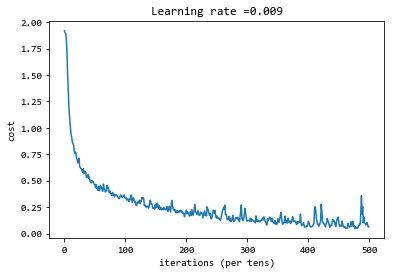

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.98703706
Test Accuracy: 0.84166676


In [27]:
_, _, parameters = model(X_train, Y_train.T, X_test, Y_test.T,num_epoches=500)


Cost after epoch 0: 1.920183
Cost after epoch 5: 1.885450
Cost after epoch 10: 1.849220
Cost after epoch 15: 1.736100
Cost after epoch 20: 1.511072
Cost after epoch 25: 1.277277
Cost after epoch 30: 1.116706
Cost after epoch 35: 0.996151
Cost after epoch 40: 0.918852
Cost after epoch 45: 0.846604
Cost after epoch 50: 0.797367
Cost after epoch 55: 0.749053
Cost after epoch 60: 0.698228
Cost after epoch 65: 0.665810
Cost after epoch 70: 0.645770
Cost after epoch 75: 0.622721
Cost after epoch 80: 0.596309
Cost after epoch 85: 0.565947
Cost after epoch 90: 0.543165
Cost after epoch 95: 0.509978
Cost after epoch 100: 0.497773
Cost after epoch 105: 0.468780
Cost after epoch 110: 0.455361
Cost after epoch 115: 0.436660
Cost after epoch 120: 0.450471
Cost after epoch 125: 0.414184
Cost after epoch 130: 0.400057
Cost after epoch 135: 0.399521
Cost after epoch 140: 0.371492
Cost after epoch 145: 0.359385
Cost after epoch 150: 0.347719
Cost after epoch 155: 0.337510
Cost after epoch 160: 0.333093

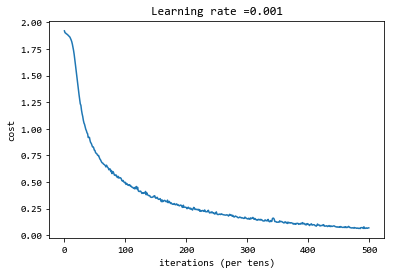

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9925925
Test Accuracy: 0.90000004


In [28]:
_, _, parameters = model(X_train, Y_train.T, X_test, Y_test.T,learning_rate=0.001,num_epoches=500)


## 重新编写一个带dropout和BatchNorm的程序

In [1]:
# placeholder

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from cnn_utils import load_dataset,random_mini_batches

%matplotlib inline
np.random.seed(1)

import time

## 源数据处理

In [2]:
X_train_orig,Y_train_orig,X_test_orig,Y_test_orig,classes=load_dataset()

X_train=X_train_orig/255.0
X_test=X_test_orig/255.0
Y_train=np.eye(6)[Y_train_orig.reshape(-1)]
Y_test=np.eye(6)[Y_test_orig.reshape(-1)]

print("X_train={}".format(X_train.shape))
print("X_test={}".format(X_test.shape))
print("Y_train={}".format(Y_train.shape))
print("Y_test={}".format(Y_test.shape))


X_train=(1080, 64, 64, 3)
X_test=(120, 64, 64, 3)
Y_train=(1080, 6)
Y_test=(120, 6)


In [3]:
learning_rate=0.001
epochs=100
minibatch_size=64

X= Tensor("X:0", shape=(?, 64, 64, 3), dtype=float32)
Y= Tensor("Y:0", shape=(?, 6), dtype=float32)
W1= Tensor("W1/read:0", shape=(4, 4, 3, 8), dtype=float32)
b1= Tensor("b1/read:0", shape=(1, 1, 1, 8), dtype=float32)
W2= Tensor("W2/read:0", shape=(2, 2, 8, 16), dtype=float32)
b2= Tensor("b2/read:0", shape=(1, 1, 1, 16), dtype=float32)
Z1= Tensor("Z1:0", shape=(?, 64, 64, 8), dtype=float32)
A1= Tensor("A1:0", shape=(?, 64, 64, 8), dtype=float32)
P1= Tensor("P1:0", shape=(?, 8, 8, 8), dtype=float32)
Z2= Tensor("Z2:0", shape=(?, 8, 8, 16), dtype=float32)
A2= Tensor("A2:0", shape=(?, 8, 8, 16), dtype=float32)
P2= Tensor("P2:0", shape=(?, 16, 16, 8), dtype=float32)
F1= Tensor("Flatten/Reshape:0", shape=(?, 2048), dtype=float32)
Z3= Tensor("fully_connected/BiasAdd:0", shape=(?, 6), dtype=float32)
0.91 seconds later,cost after epoch 0: 1.891941
1.97 seconds later,cost after epoch 10: 0.699376
3.02 seconds later,cost after epoch 20: 0.384429
4.05 seconds later,cost after epoch 30: 0.237787
5.

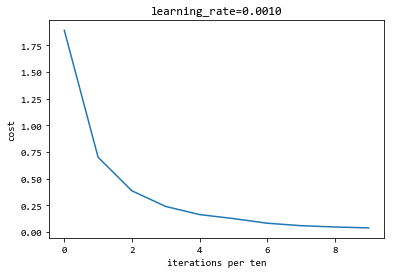

prediction_op= Tensor("ArgMax:0", shape=(?,), dtype=int64)
actual_op= Tensor("ArgMax_1:0", shape=(?,), dtype=int64)
correct_prediction= Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy= Tensor("Mean_1:0", shape=(), dtype=float32)
train accuracy=100.00%
test accuracy=94.17%


In [4]:
tf.reset_default_graph()
m,n_W0,n_H0,n_C0=X_train.shape
n_y=Y_train.shape[1]


X=tf.placeholder(tf.float32,shape=(None,n_W0,n_H0,n_C0),name='X')
Y=tf.placeholder(tf.float32,shape=(None,n_y),name='Y')
print("X=",X)
print("Y=",Y)

W1=tf.get_variable("W1",shape=(4,4,3,8),dtype=tf.float32,initializer=tf.contrib.layers.xavier_initializer())
b1=tf.get_variable("b1",shape=(1,1,1,8),dtype=tf.float32,initializer=tf.zeros_initializer())
W2=tf.get_variable("W2",shape=(2,2,8,16),dtype=tf.float32,initializer=tf.contrib.layers.xavier_initializer())
b2=tf.get_variable("b2",shape=(1,1,1,16),dtype=tf.float32,initializer=tf.zeros_initializer())

print("W1=",str(W1))
print("b1=",str(b1))
print("W2=",str(W2))
print("b2=",str(b2))

Z1=tf.nn.conv2d(input=X,filter=W1,strides=[1,1,1,1],padding='SAME',name='Z1')
A1=tf.nn.relu(Z1,name='A1')
P1=tf.nn.max_pool(value=A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME',name='P1')

Z2=tf.nn.conv2d(input=P1,filter=W2,strides=[1,1,1,1],padding='SAME',name='Z2')
A2=tf.nn.relu(Z2,name='A2')
P2=tf.nn.max_pool(value=A1,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME',name='P2')

F1=tf.contrib.layers.flatten(P2)
Z3=tf.contrib.layers.fully_connected(F1,num_outputs=6,activation_fn=None)

print("Z1=",str(Z1))
print("A1=",str(A1))
print("P1=",str(P1))
print("Z2=",str(Z2))
print("A2=",str(A2))
print("P2=",str(P2))
print("F1=",str(F1))
print("Z3=",str(Z3))

cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y)) 
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

init=tf.global_variables_initializer()

stime=time.time()



with tf.Session() as sess:
    costs=[]
    sess.run(init)
    seed=1
    for epoch in range(epochs):
        minibatch_cost=0.
        num_minibatches=int(m/minibatch_size)
        minibatches=random_mini_batches(X_train,Y_train,minibatch_size,seed)
        
        seed+=1                  
        
        for minibatch in minibatches:        
            (minibatch_X,minibatch_Y)=minibatch
            temp_cost,_=sess.run([cost,optimizer],feed_dict={X:minibatch_X,Y:minibatch_Y})
            minibatch_cost+=temp_cost/num_minibatches

    
        if epoch%10==0:
            print("{:,.2f} seconds later,cost after epoch {:,.0f}: {:,.6f}".format(time.time()-stime,epoch,minibatch_cost))
            costs.append(minibatch_cost)            
    plt.plot(np.squeeze(costs))
    plt.xlabel("iterations per ten")
    plt.ylabel("cost")
    plt.title("learning_rate={:,.4f}".format(learning_rate))
    plt.show()

    prediction_op=tf.argmax(Z3,1)
    actual_op=tf.argmax(Y,1)
    correct_prediction=tf.equal(prediction_op,actual_op)
    accuracy=tf.reduce_mean( tf.cast(correct_prediction,"float")) 
    print("prediction_op=",str(prediction_op))
    print("actual_op=",str(actual_op))
    print("correct_prediction=",str(correct_prediction))
    print("accuracy=",str(accuracy))
    
    print("train accuracy={:,.2%}".format(sess.run(accuracy,feed_dict={Y:Y_train,X:X_train})))
    print("test accuracy={:,.2%}".format(sess.run(accuracy,feed_dict={Y:Y_test,X:X_test})))    
